In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
gtzan = '/content/drive/MyDrive/MiniProject/GTZANOld'
genre_folders=os.listdir(gtzan)
print(genre_folders)
genre_files={}
for genre in genre_folders:
  genre_files[genre]=os.listdir(os.path.join(gtzan,genre))
print(genre_files)

['pop', 'country', 'disco', 'metal', 'blues', 'reggae', 'rock', 'hiphop', 'classical', 'jazz']
{'pop': ['pop.00002.wav', 'pop.00001.wav', 'pop.00007.wav', 'pop.00004.wav', 'pop.00006.wav', 'pop.00005.wav', 'pop.00000.wav', 'pop.00008.wav', 'pop.00009.wav', 'pop.00003.wav', 'pop.00020.wav', 'pop.00013.wav', 'pop.00015.wav', 'pop.00021.wav', 'pop.00012.wav', 'pop.00011.wav', 'pop.00022.wav', 'pop.00017.wav', 'pop.00019.wav', 'pop.00010.wav', 'pop.00016.wav', 'pop.00014.wav', 'pop.00018.wav', 'pop.00026.wav', 'pop.00025.wav', 'pop.00036.wav', 'pop.00033.wav', 'pop.00024.wav', 'pop.00030.wav', 'pop.00023.wav', 'pop.00028.wav', 'pop.00031.wav', 'pop.00037.wav', 'pop.00029.wav', 'pop.00035.wav', 'pop.00034.wav', 'pop.00027.wav', 'pop.00032.wav', 'pop.00046.wav', 'pop.00044.wav', 'pop.00050.wav', 'pop.00042.wav', 'pop.00048.wav', 'pop.00049.wav', 'pop.00043.wav', 'pop.00041.wav', 'pop.00040.wav', 'pop.00047.wav', 'pop.00045.wav', 'pop.00038.wav', 'pop.00039.wav', 'pop.00051.wav', 'pop.00054.w

In [19]:
import librosa
import numpy as np
# def extract mfcc features given a file path
def extract_and_pad_stft_features(file_path, max_len=200):
    # Load audio file using librosa
    y, sr = librosa.load(file_path, sr=None)
    # Compute STFT
    stft = np.abs(librosa.stft(y))
    # Pad or trim STFT to max_len
    if stft.shape[1] < max_len:
        stft = np.pad(stft, ((0, 0), (0, max_len - stft.shape[1])), mode='constant')
    else:
        stft = stft[:, :max_len]
    return stft

In [20]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
stft_x = []
stft_y = []

for genre, files in genre_files.items():
    for file in tqdm(files, desc=f"Processing {genre}"):
        mfcc = extract_and_pad_stft_features(os.path.join(gtzan, genre, file))
        if mfcc is not None:
          stft_x.append(mfcc)
          stft_y.append(genre_folders.index(genre))


Processing jazz: 100%|██████████| 99/99 [00:34<00:00,  2.88it/s]


In [21]:
max_length = max([stft.shape[1] for stft in stft_x])

# Pad the sequences to have the same length
stft_X = np.array([np.pad(stft, ((0, 0), (0, max_length - stft.shape[1])), mode='constant') for stft in stft_x])

# Convert y to a NumPy array
stft_y = np.array(stft_y)

# Add a channel dimension to X
stft_X = stft_X[..., np.newaxis]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(stft_X, stft_y, test_size=0.2, random_state=42)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(genre_folders), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
25/25 [==============================] - 47s 2s/step - loss: 7.6214 - accuracy: 0.1777 - val_loss: 1.9713 - val_accuracy: 0.2950
Epoch 2/15
25/25 [==============================] - 45s 2s/step - loss: 1.3568 - accuracy: 0.5757 - val_loss: 1.7406 - val_accuracy: 0.4150
Epoch 3/15
25/25 [==============================] - 45s 2s/step - loss: 0.4498 - accuracy: 0.8698 - val_loss: 2.4425 - val_accuracy: 0.4000
Epoch 4/15
25/25 [==============================] - 45s 2s/step - loss: 0.1887 - accuracy: 0.9412 - val_loss: 2.4415 - val_accuracy: 0.4400
Epoch 5/15
25/25 [==============================] - 45s 2s/step - loss: 0.0792 - accuracy: 0.9837 - val_loss: 3.2784 - val_accuracy: 0.4050
Epoch 6/15
25/25 [==============================] - 45s 2s/step - loss: 0.1891 - accuracy: 0.9587 - val_loss: 3.8234 - val_accuracy: 0.3900
Epoch 7/15
25/25 [==============================] - 45s 2s/step - loss: 0.0414 - accuracy: 0.9900 - val_loss: 3.6682 - val_accuracy: 0.4050
Epoch 8/15
25/25 [==

In [23]:
model.save('/content/drive/MyDrive/MiniProject/Models/cnn-stft-15-old.h5')

In [24]:
loss, overall_accuracy = model.evaluate(X_test, y_test)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")

genre_accuracies = []
genre_names = []
genre_to_label = {genre: i for i, genre in enumerate(genre_folders)}
# X_train, X_test, y_train, y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.3, random_state=50)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

for genre in genre_folders:
    genre_index = genre_to_label[genre]
    genre_indices = np.where(y_true == genre_index)[0]
    if len(genre_indices) > 0:
        genre_accuracy = np.mean(y_pred_classes[genre_indices] == y_true[genre_indices])
        genre_accuracies.append(genre_accuracy)
        genre_names.append(genre.capitalize())
        print(f"Accuracy for {genre.capitalize()}: {genre_accuracy * 100:.2f}%")



7/7 [==============================] - 2s 263ms/step - loss: 3.5786 - accuracy: 0.4450
Overall Test Accuracy: 44.50%
7/7 [==============================] - 2s 265ms/step
Accuracy for Pop: 47.62%
Accuracy for Country: 8.33%
Accuracy for Disco: 29.17%
Accuracy for Metal: 72.73%
Accuracy for Blues: 46.67%
Accuracy for Reggae: 42.86%
Accuracy for Rock: 17.65%
Accuracy for Hiphop: 40.00%
Accuracy for Classical: 72.73%
Accuracy for Jazz: 47.37%


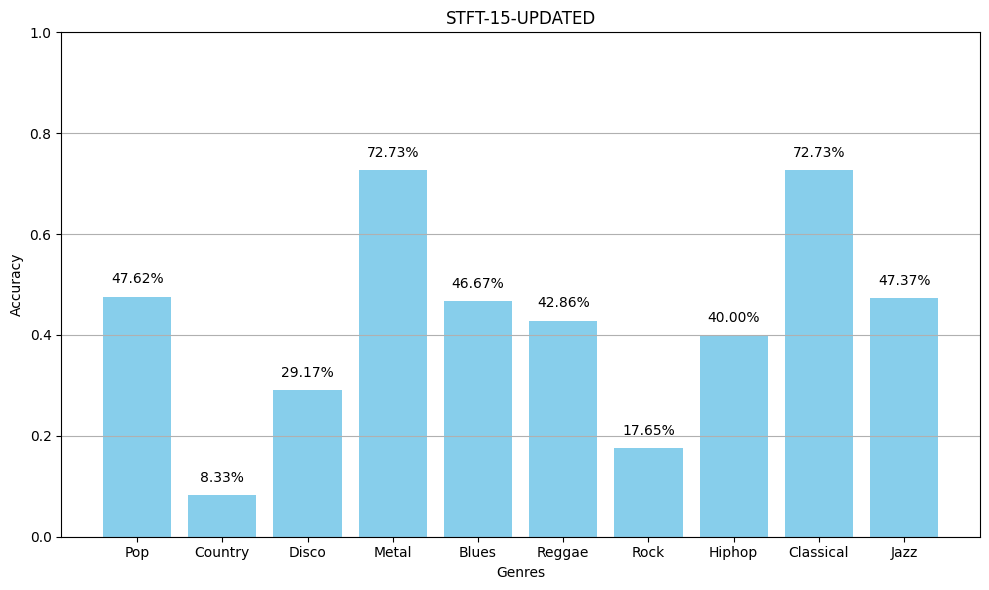

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(genre_names, genre_accuracies, color='skyblue')
plt.title('STFT-15-OLD')
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set ylim to 0-100%
plt.grid(axis='y')
for i, v in enumerate(genre_accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

20 Epoch

In [26]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(genre_folders), activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
25/25 [==============================] - 47s 2s/step - loss: 6.3007 - accuracy: 0.1690 - val_loss: 2.0070 - val_accuracy: 0.3250
Epoch 2/20
25/25 [==============================] - 45s 2s/step - loss: 1.5071 - accuracy: 0.4956 - val_loss: 1.7320 - val_accuracy: 0.4200
Epoch 3/20
25/25 [==============================] - 45s 2s/step - loss: 0.6390 - accuracy: 0.7872 - val_loss: 1.6746 - val_accuracy: 0.5050
Epoch 4/20
25/25 [==============================] - 45s 2s/step - loss: 0.1914 - accuracy: 0.9412 - val_loss: 1.8846 - val_accuracy: 0.5250
Epoch 5/20
25/25 [==============================] - 45s 2s/step - loss: 0.0713 - accuracy: 0.9912 - val_loss: 2.6387 - val_accuracy: 0.5650
Epoch 6/20
25/25 [==============================] - 45s 2s/step - loss: 0.0450 - accuracy: 0.9950 - val_loss: 2.6105 - val_accuracy: 0.5400
Epoch 7/20
25/25 [==============================] - 45s 2s/step - loss: 0.0290 - accuracy: 0.9962 - val_loss: 2.7525 - val_accuracy: 0.5400
Epoch 8/20
25/25 [==

In [27]:
model2.save('/content/drive/MyDrive/MiniProject/Models/cnn-stft-20-old.h5')
loss, overall_accuracy = model2.evaluate(X_test, y_test)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")

genre_accuracies = []
genre_names = []
genre_to_label = {genre: i for i, genre in enumerate(genre_folders)}
# X_train, X_test, y_train, y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.3, random_state=50)
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

for genre in genre_folders:
    genre_index = genre_to_label[genre]
    genre_indices = np.where(y_true == genre_index)[0]
    if len(genre_indices) > 0:
        genre_accuracy = np.mean(y_pred_classes[genre_indices] == y_true[genre_indices])
        genre_accuracies.append(genre_accuracy)
        genre_names.append(genre.capitalize())
        print(f"Accuracy for {genre.capitalize()}: {genre_accuracy * 100:.2f}%")



7/7 [==============================] - 2s 266ms/step - loss: 2.7454 - accuracy: 0.5000
Overall Test Accuracy: 50.00%
7/7 [==============================] - 2s 269ms/step
Accuracy for Pop: 61.90%
Accuracy for Country: 33.33%
Accuracy for Disco: 37.50%
Accuracy for Metal: 63.64%
Accuracy for Blues: 60.00%
Accuracy for Reggae: 50.00%
Accuracy for Rock: 5.88%
Accuracy for Hiphop: 45.00%
Accuracy for Classical: 81.82%
Accuracy for Jazz: 47.37%


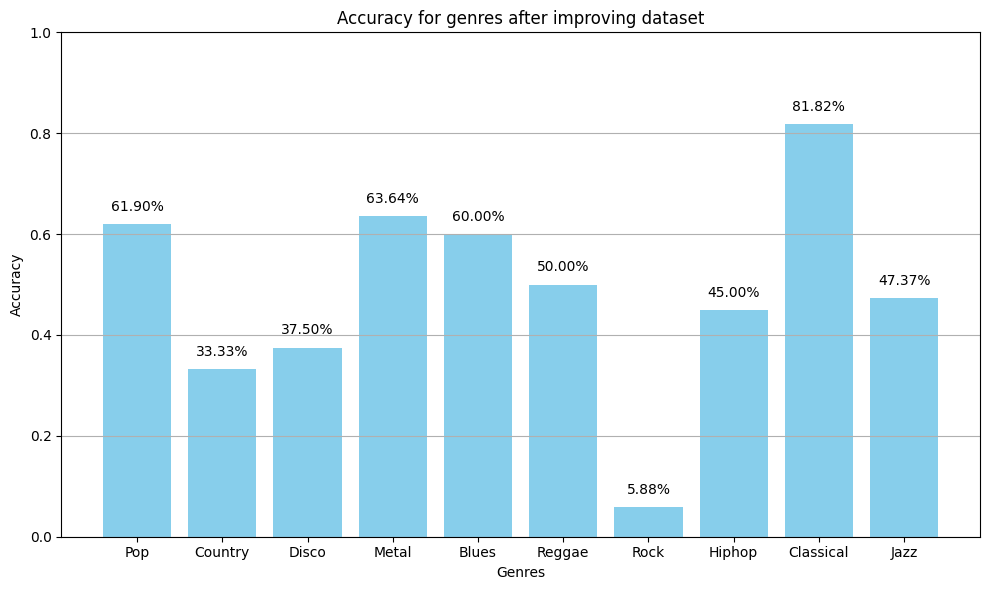

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(genre_names, genre_accuracies, color='skyblue')
plt.title('STFT-20-OLD')
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set ylim to 0-100%
plt.grid(axis='y')
for i, v in enumerate(genre_accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()